In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.fftpack import fft,ifft
from schrodinger import Schrodinger
import matplotlib.pyplot as plt
import scipy
import sympy as sp

from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='jshtml')
import seaborn as sns

#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('poster', font_scale=0.9,  rc={"lines.linewidth": 5})
sns.set_palette(sns.color_palette("deep"))

In [3]:
L = 1.0
m = 0.1
hbar = 1.0

In [4]:
# Energy eigenstates:
@np.vectorize
def phiF(x,n=1):
    k = np.pi*n/L
    f = np.sqrt(2/L)*np.sin(k*x)
    
    return  f

def energy(n=1):
    k = np.pi*n/L
    return hbar**2*k**2/(2*m)

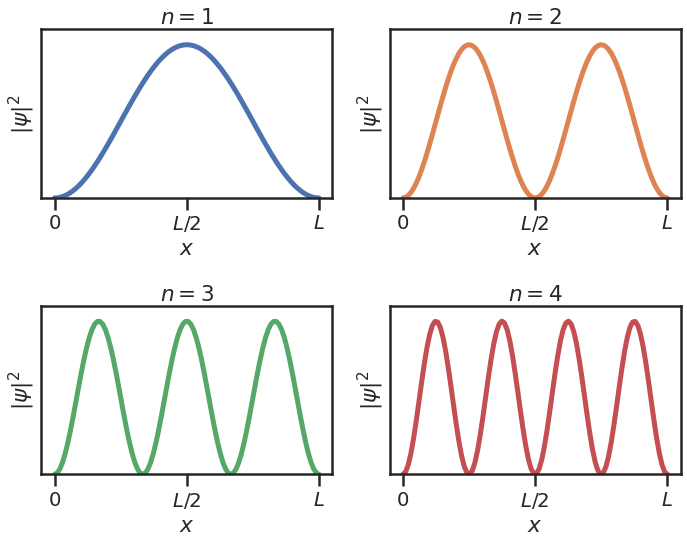

In [7]:
fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(10,8))

x = np.linspace(0.,L,100)
n = 1
colors = sns.color_palette("deep", len(axs.reshape(-1)))
energies = []
for ax in axs.reshape(-1):
    energies.append(energy(n))
    ax.plot(x,phiF(x,n=n)**2,linestyle='-',label=r'$n=%i$' %n,c=colors[n-1])
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$|\psi|^2$')
    ax.set_xticks([0,0.5,1])
    ax.set_yticks([])
    ax.set_xticklabels([r'$0$',r'$L/2$',r'$L$'])
    ax.set_title(r'$n = %i$' %n)
    ax.set_ylim(0,1.1*np.max(phiF(x,n=1)**2))
    n += 1

plt.tight_layout()
plt.savefig('infiniteWellDensties.png')
plt.show()

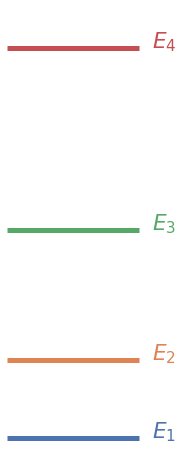

In [8]:
fig = plt.figure(figsize=(3,7))
for i,e in enumerate(energies):
    n = i+1
    plt.hlines(y=e,xmin=0.,xmax=1,colors=colors[n-1])
    plt.annotate(r'$E_{%i}$'%n, xy=(1.1,e),color=colors[n-1])
plt.xlim(0,1.1)
plt.ylim(0,1.1*max(energies))
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('infiniteWellEnergies.png')
plt.show()

In [95]:
#Initial wave function:
@np.vectorize
def psi0(x,sigma=0.2,mu=0.5,k0=5):
    norm = 1/(np.pi*sigma**2)**(1/4)
    f = np.exp(-(x-mu)**2/(2*sigma**2))
    f *= np.exp(complex(0,k0*(x-mu)))
    
    return  norm*f

# Coefficients:
def coeff(psi0,n):
    if n == 0:
        return 0.0
    def funcR(x):
        f = phiF(x,n)*psi0(x)
        return np.real(f)
    
    def funcI(x):
        f = phiF(x,n)*psi0(x)
        return np.imag(f)
    
    cR = scipy.integrate.quad(funcR,0,L,limit=500)[0]
    cI = scipy.integrate.quad(funcI,0,L,limit=500)[0]
    return complex(cR,cI)

coeffList = [coeff(psi0,n) for n in range(500)]

# Wave function at time t
@np.vectorize
def psi(x,t):
    f = 0.0
    for n,cn in enumerate(coeffList):
        En = energy(n)
        f += cn*np.exp(-complex(0,En*t/hbar))*phiF(x,n)
    return f

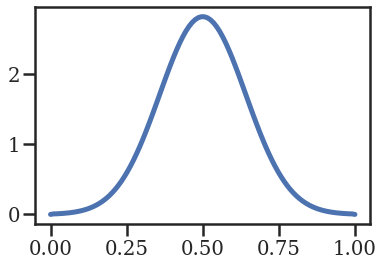

In [97]:
x = np.linspace(0,L,100)
p0 = np.abs(psi(x,t=0))**2
plt.plot(x,p0)
plt.show()

In [98]:
dt = 0.001

In [99]:
pList = [np.abs(psi(x,t=t))**2 for t in np.linspace(0,0.1,100)]

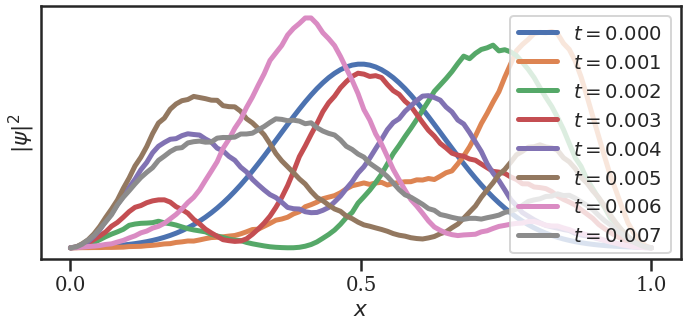

In [118]:
fig = plt.figure(figsize=(10,5))
x = np.linspace(0,L,100)
for i,p in enumerate(pList[:40:5]):
    plt.plot(x,p,label=r'$t=%1.3f$' %(i*dt))

plt.xlabel(r'$x$')
plt.ylabel(r'$|\psi|^2$')
plt.xticks([0,0.5,1])
plt.yticks([])
# plt.xticklabels([r'$0$',r'$L/2$',r'$L$'])
plt.legend()
plt.tight_layout()
plt.savefig('infiniteWellPackage.png')
plt.show()

### Animation:

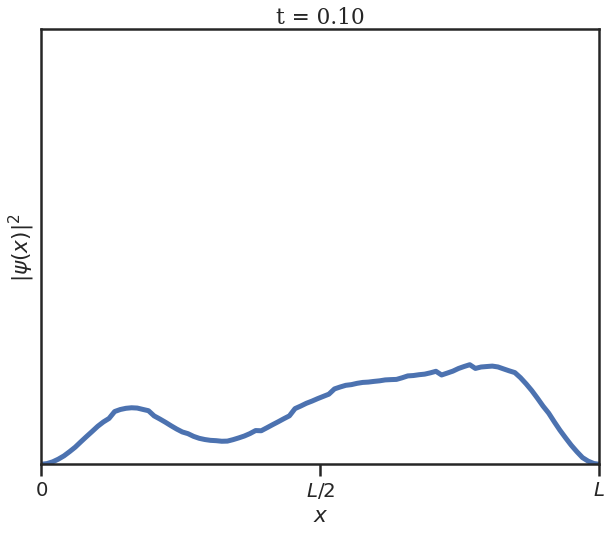

In [122]:
######################################################################
# Set up plot
fig,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(10,8))
psi_x0 = np.abs(psi(x,t=0.0))**2
psi_x_line, = ax1.plot([], [])
ax1.set_xlabel('$x$')
ax1.set_ylabel(r'$|\psi(x)|^2$')
title = ax1.set_title("")
ax1.set_xlim(x.min(),x.max())
ax1.set_ylim(0,max(np.abs(psi_x0)**2))
ax1.set_xticks([0,0.5,1])
ax1.set_yticks([])
ax1.set_xticklabels([r'$0$',r'$L/2$',r'$L$'])

dt = 3e-4
# Animate plot
def init():
    psi_x_line.set_data([], [])
    title.set_text("")
    return (psi_x_line, title)

def animate(i):
    t = i*dt
    psi_x = psi(x,t=t)
    psi_x_line.set_data(x, np.abs(psi_x)**2)

    title.set_text("t = %.2f" % t)
        
    return (psi_x_line, title)

# call the animator.  blit=True means only re-draw the parts that have changed.

t_max = 10e-2
frames = int(t_max/dt)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=100, blit=True)

#Para salvar corretamente, tem que descomentar a linha de baixo
anim.save('infiniteWellPackage.mp4', fps=15, extra_args=['-vcodec', 'libx264'])

#Para ver o video no notebook deve comentar a linha de cima
# plt.close()
# anim
